<a href="https://colab.research.google.com/github/DJCordhose/CNTK/blob/master/ts_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@vidbina on GitHub, Twitter and Instagram and david@asabina.de by e-mail.

Reach out if you need help!

# Episode 1 -- Overview

<!-- high-level banter -->

## Time Series

A time series is a **time-ordered** collection of data points sampled at **fixed intervals**.

![general-topology](https://gitlab.com/asabina/edu/pyspark-workshop/raw/setup/tooling/docs/assets/timeseries.svg)

## Apache Spark

A general compute platform.

![general-topology](https://gitlab.com/asabina/edu/pyspark-workshop/raw/setup/tooling/docs/assets/general-topology.svg)

Pay attention to:
 - versions
 - package availability

# Episode 2 -- Setup

## Install Java, Spark and the Python `findspark` package

As mentioned before, Spark is a JVM application and therefore we need to install OpenJDK to be able to run it. After installing OpenJDK, we can continue installing Spark, followed by the `findspark` package which we use in Python to make `pyspark` accessible as a regular library.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

## Setup environment variables for this notebook execution environment

We need the right environment variables setup in our execution environment for Java and Spark to work.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

## Initiate a `SparkSession`

[Python API docs](https://spark.apache.org/docs/2.4.4/api/python/index.html)

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("s2019").getOrCreate()
sc = spark.sparkContext
spark

## Example 1

Do something with Spark, like for example modelling a data frame that contains the values of $y = 2 + \frac{1}{10}x^2$ for $0 \leq x < 1000$

In [0]:
from pyspark.sql import Row

df = spark.createDataFrame([
    Row(x=x, y=2+(0.1*x**2)) for x in range(1000)
])
df.show(3)

## Example 2

Let's actually run some code on the Spark worker.

In [0]:
file = "{}/README.md".format(os.environ["SPARK_HOME"])
logData = spark.read.text(file).cache()
print(type(logData))

numAs = logData.filter(logData.value.contains('a')).count()
numZs = logData.filter(logData.value.contains('z')).count()
periods = logData.filter(logData.value.contains('.')).count()

{
    'a': numAs,
    'z': numZs,
    '.': periods
}

# -

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">how statistics people feel watching people in machine learning solve problems <a href="https://t.co/tR5NbdqPKJ">pic.twitter.com/tR5NbdqPKJ</a></p>&mdash; Kareem🔥10x statistician🔥Carr (@kareem_carr) <a href="https://twitter.com/kareem_carr/status/1160967555479166976?ref_src=twsrc%5Etfw">August 12, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

# Episode 3 -- Playtime

## Pandas

In [0]:
import pandas as pd

In [0]:
birthdays = pd.date_range('1988-04-01', name='birthday', periods=150, freq=pd.DateOffset(years=1))
birthdays #.to_frame(index=False)

DatetimeIndex(['1988-04-01', '1989-04-01', '1990-04-01', '1991-04-01',
               '1992-04-01', '1993-04-01', '1994-04-01', '1995-04-01',
               '1996-04-01', '1997-04-01',
               ...
               '2128-04-01', '2129-04-01', '2130-04-01', '2131-04-01',
               '2132-04-01', '2133-04-01', '2134-04-01', '2135-04-01',
               '2136-04-01', '2137-04-01'],
              dtype='datetime64[ns]', name='birthday', length=150, freq='<DateOffset: years=1>')

In [0]:
unstamped_age_df = pd.DataFrame({'age': range(0, 32)})

In [0]:
stamped_birthday_age_df = unstamped_age_df.join(birthdays.to_frame(index=False)).set_index('birthday')
stamped_birthday_age_df


In [0]:
stamped_birthday_age_df.plot(marker='x')

In [0]:
stamped_day_age_df = stamped_birthday_age_df.asfreq('D', method='pad')
stamped_day_age_df.plot()

In [0]:
stamped_age_df = stamped_day_age_df.join(stamped_birthday_age_df, rsuffix="_r")
stamped_age_df["2000-03-25":"2000-04-05"]

In [0]:
import matplotlib.pyplot as plt

plt.figure()
stamped_age_df["1988":"1996"].plot(marker='.')
plt.legend(loc='best')

## Pandas DataFrame to Apache Spark

In [0]:
stamped_age_sdf = spark.createDataFrame(stamped_age_df)
stamped_age_sdf.show()

+---+-----+
|age|age_r|
+---+-----+
|  0|  0.0|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
|  0|  NaN|
+---+-----+
only showing top 20 rows



## Parallelize on Apache Spark

### RDD

In [0]:
data = range(10)
data_rdd = sc.parallelize(data)
data_rdd

PythonRDD[96] at RDD at PythonRDD.scala:53

In [0]:
data_rdd.map(lambda x: x*2).collect()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

### DataFrame [[doc](https://spark.apache.org/docs/preview/api/python/pyspark.sql.html#pyspark.sql.DataFrame)]

In [0]:
from pyspark.sql.functions import udf

double = lambda x: x*2
double_udf = udf(double)

data_df = spark.createDataFrame(range(10), "int") # distributed
data_df.select("value", double_udf("value").alias("value_x2")).show()

+-----+--------+
|value|value_x2|
+-----+--------+
|    0|       0|
|    1|       2|
|    2|       4|
|    3|       6|
|    4|       8|
|    5|      10|
|    6|      12|
|    7|      14|
|    8|      16|
|    9|      18|
+-----+--------+



# Episode 4 -- Housekeeping

## Operations

### Filter

In [0]:
only_tens = lambda x: x % 10 == 0
list(filter(only_tens, range(0,100)))

### Map

In [0]:
triple = lambda x: x*3
list(map(triple, range(0, 100)))

### Reduce

In [0]:
from functools import reduce
reduce((lambda x, y: x + y), range(0,100))

4950

## Google Colab Housekeeping

One can use the `google.colab.files` module to upload some data to the Colab environment.

> Source the AirPassengers.csv dataset from [github.com/vincentarelbundock/Rdatasets](https://github.com/vincentarelbundock/Rdatasets/blob/master/csv/datasets/AirPassengers.csv) inside the `csv/datasets` directory or alternatively from [github.com/jbrownlee/Datasets](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv)

In [0]:
from google.colab import files
files.upload()

### Running Commands

Note how we prefix commands with an exclamation mark to run shell commands on our Colab environment. This has been demonstrated while installing software on our driver machine.

In [0]:
!ls

Observe how one plots the data in the AirPassengers.csv file using the `pandas` package.

# Episode 5 -- Intuition

## Fundamentals


### Air Passengers Time Series

In [0]:
import pandas as pd

air_passengers_series = pd.read_csv("AirPassengers.csv")

In [0]:
air_passengers_series.plot(x='time', y='value')

### Random Data

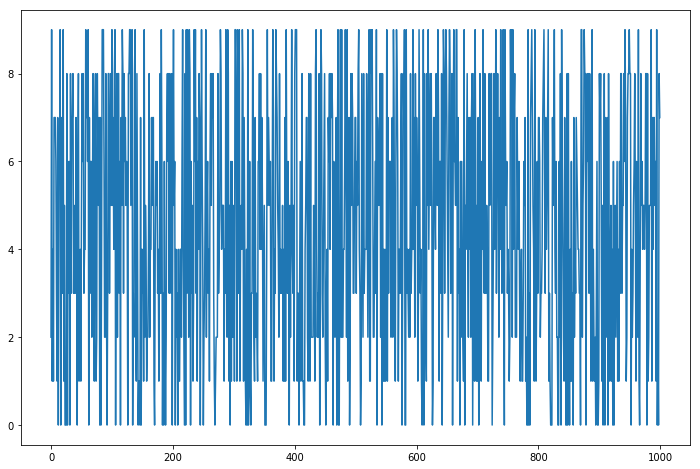

In [0]:
from random import randrange, seed
from matplotlib import pyplot as plt

seed(1)
random_series = [randrange(10) for i in range(1000)]

plt.plot(random_series)
plt.show()

### Random Walk

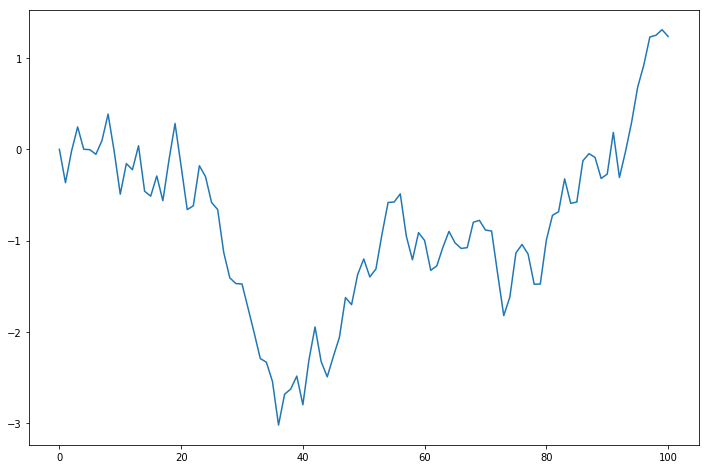

In [0]:
from functools import reduce
from matplotlib import pyplot as plt
from random import random, seed

seed(1)
drunken_walk = lambda acc, new: acc + [acc[-1]+(random()-0.5)]
random_walk = reduce(drunken_walk, range(0, 100), [0])

plt.plot(random_walk)
plt.show()

### Indexing (housekeeping)



> We'll be using DateTime indexed data frame wherever we can.

In [0]:
#air_passengers.set_index(pd.date_range(start="1949", end="1961", freq='M'))
air_passengers = air_passengers_dataset.drop(columns=['Unnamed: 0', 'time']).set_index(pd.date_range(start="1949", end="1961", freq='M'))
air_passengers["1949":"1950"].plot()

### Time Series Properties

In [0]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 12, 8

#### Decompose (additive)

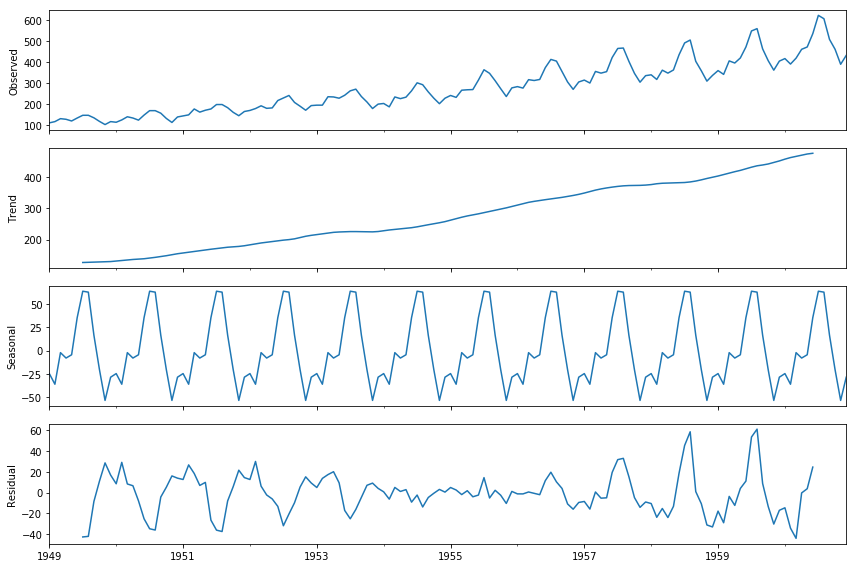

In [0]:
additive_decomp = seasonal_decompose(air_passengers.value, model='additive')
ax_add = additive_decomp.plot()

#### Decompose (multiplicative)

In [0]:
multiplicative_properties = seasonal_decompose(air_passengers.value, model='multiplicative')
ax_mult = multiplicative_properties.plot()

#### Decompose (the staircase)

In [0]:
birthdays_decomp = seasonal_decompose(stamped_day_age_df, model='multiplicative')
ax_bd = birthdays_decomp.plot()

ValueError: ignored

# Episode 6 -- Linear Calculus and Statistics?

### 101

[Notation in probability and statistics on Wikipedia](https://en.wikipedia.org/wiki/Notation_in_probability_and_statistics)

[List of mathematical symbols on Wikipedia](https://en.wikipedia.org/wiki/List_of_mathematical_symbols)

[OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) [RegressionResults](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

#### Linear Regression [[wiki](https://en.wikipedia.org/wiki/Linear_regression)]

$\displaystyle y_i = \beta_0 + \sum_{n=1}^{N} \beta_n x_{in} + \varepsilon_i$

${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i1}+\cdots +\beta _{p}x_{ip}+\varepsilon _{i}=\mathbf {x} _{i}^{\mathsf {T}}{\boldsymbol {\beta }}+\varepsilon _{i},\qquad i=1,\ldots ,N,}$

In [0]:
import statsmodels.api as sm
Y = [1, 3, 4, 5, 2, 3, 4]
X = range(1, 8)
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.9608
Date:                Sun, 13 Oct 2019   Prob (F-statistic):              0.372
Time:                        21:31:53   Log-Likelihood:                -10.854
No. Observations:                   7   AIC:                             25.71
Df Residuals:                       5   BIC:                             25.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1429      1.141      1.879      0.119      -0.789       5.075
x1             0.2500      0.255      0.980      0.372      -0.406       0.906
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.743
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.482
Skew:                           0.206   Prob(JB):                        0.786
Kurtosis:                       1.782   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Polynomial Regression [[wiki](https://en.wikipedia.org/wiki/Polynomial_regression)]

${\displaystyle y_i=\beta _{0}+ \sum_{n=1}^{N}\beta _{n}x_i^n+\varepsilon_i .\,}$

${\displaystyle y_i = \beta _{0}+\beta _{1}x_i+\beta _{2}x_i^{2}+\beta _{3}x_i^{3}+\cdots +\beta _{n}x_i^{n}+\varepsilon_i .\,}$

#### AR(p)

$\displaystyle X_{t}=c+\sum _{i=1}^{p}\varphi _{i}X_{t-i}+\varepsilon _{t}.\,$

> What happens at $|\varphi| \geq 1$?

> $\varepsilon$ must be **i.i.d.** i.e.: $\varepsilon_t \sim N(0, \sigma^2)$

##### Remember the random walk?

If the root of a process's characteristic equation is greater than one, we are dealing with an explosive process.

In [0]:
from functools import reduce
from matplotlib import pyplot as plt
from random import random, seed

seed(1)
phi=0 # <<<<
epsilon=2
                                      #VVV
drunken_walk = lambda acc, new: acc + [phi*acc[-1]+(epsilon*(random()-0.5))]
series = reduce(drunken_walk, range(0, 100), [0])

plt.plot(series)
plt.show()

In [0]:
walk_decomp = seasonal_decompose(series, model='additive')
ax_walk = walk_decomp.plot()

#### MA(q)

$\displaystyle X_{t}=\mu +\varepsilon _{t}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}\,$

#### ARMA(p, q)

$\displaystyle X_{t}=c+\varepsilon _{t}+\sum _{i=1}^{p}\varphi _{i}X_{t-i}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}.\,$

$\displaystyle\left(1-\sum _{i=1}^{p'}\varphi _{i}L^{i}\right)X_{t}=\left(1+\sum _{i=1}^{q}\theta _{i}L^{i}\right)\varepsilon _{t}\;$

$L$ is the [lag operator](https://en.wikipedia.org/wiki/Lag_operator) such that $L^iX_t = X_{t-i}$

$\displaystyle\left(X_t -\sum _{i=1}^{p'}\varphi _{i}X_{t-i}\right)=\left(\varepsilon_t + \sum _{i=1}^{q}\theta _{i}\varepsilon_{t-1}\right)\,$

#### ARIMA(p,d,q) (Box-Jenkins models)


 - forecasting
   - AR: autoregression
   - I: integration
   - MA: moving average-->
   
 - moving average
 - Kalman filtering
 - exponential smoothing
 - AR

#### Stationarity

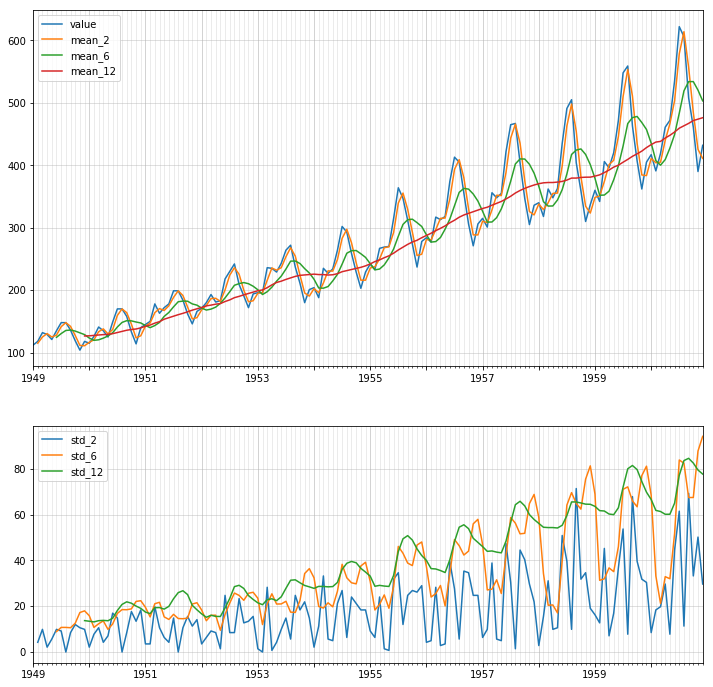

In [0]:
import matplotlib.pyplot as plt

air_passengers['mean_2'] = air_passengers['value'].rolling(window=2).mean()
air_passengers['mean_6'] = air_passengers['value'].rolling(window=6).mean()
air_passengers['mean_12'] = air_passengers['value'].rolling(window=12).mean()
air_passengers_mean = air_passengers['value'].mean()

air_passengers['std_2'] = air_passengers['value'].rolling(window=2).std()
air_passengers['std_6'] = air_passengers['value'].rolling(window=6).std()
air_passengers['std_12'] = air_passengers['value'].rolling(window=12).std()

fig, (ax0, ax1) = plt.subplots(
    nrows=2,
    gridspec_kw={'height_ratios': [3, 2]},
    figsize=(12, 12)
)

columns_magnitude = ['value', 'mean_2', 'mean_6', 'mean_12']
columns_variance = ['std_2', 'std_6', 'std_12']

air_passengers[columns_magnitude].plot(ax=ax0)
air_passengers[columns_variance].plot(ax=ax1)

for ax in [ax0, ax1]:
  ax.set_xticks(air_passengers.index, minor=True)
  ax.set_xticks(air_passengers.index[::12], minor=False)
  ax.grid(which='minor', alpha=0.3, axis='x')
  ax.grid(which='major', alpha=0.5, axis='x')
  ax.grid(which='major', alpha=0.5, axis='y')

#### Standard deviations


Remember the **68-95-99.7** rule?

${\displaystyle s={\sqrt {{\frac {1}{N-1}}\sum _{i=1}^{N}(x_{i}-{\bar {x}})^{2}}},}$

> Basing the next example on the values from Wikipedia's entry on [Standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

In [0]:
wiki_df = pd.DataFrame({ 'x': [727.7, 1086.5, 1091.0, 1361.3, 1490.5, 1956.1]})
wiki_std_df.mean()


In [0]:
wiki_df.std()

In [0]:
wiki_df.mean() - wiki_df.std()

In [0]:
 wiki_df.mean() + wiki_df.std()

#### Tests


> Do we have a non-stationary time series?



Tests the **null hypothesis** that a **unit root** is present in the sample.

##### Null Hypothesis

$H_0$: The presence of a unit root

$H_1$: stationarity or trend stationarity

Upon rejection, use **OLS**?

${\displaystyle y_{t}=D_{t}+z_{t}+\varepsilon _{t}}$

> Determine if stochastic component $z_t$ contains a unit root or is stationary.

##### Unit Root

> A unit root is a feature of some stochastic process that can cause problems in statistical inference.

In [0]:
from statsmodels.tsa.stattools import adfuller

def check_for_stationarity(data):
  (adf, pvalue, usedlag, nobs, critical, icbest) = adfuller(data.dropna())

  return [
      {
          k: v,
          'stationary': not v < adf
      } for k, v in critical.items()
  ]

check_for_stationarity(air_passengers.value)

[{'1%': -3.4816817173418295, 'stationary': False},
 {'5%': -2.8840418343195267, 'stationary': False},
 {'10%': -2.578770059171598, 'stationary': False}]

[CV](https://en.wikipedia.org/wiki/Coefficient_of_variation)

[{'1%': -3.4865346059036564, 'stationary': False},
 {'5%': -2.8861509858476264, 'stationary': False},
 {'10%': -2.579896092790057, 'stationary': False}]

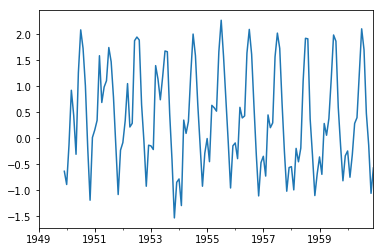

In [0]:
air_passengers_detrended = (air_passengers.value - air_passengers.value.rolling(window=12).mean()) / air_passengers.value.rolling(window=12).std()
air_passengers_detrended.plot()
check_for_stationarity(air_passengers_detrended)

[{'1%': -3.4816817173418295, 'stationary': False},
 {'5%': -2.8840418343195267, 'stationary': True},
 {'10%': -2.578770059171598, 'stationary': True}]

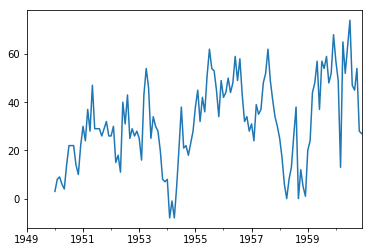

In [0]:
air_passengers_diff_by_12 = air_passengers.value - air_passengers.value.shift(12)
air_passengers_diff_by_12.plot()
check_for_stationarity(air_passengers_diff_by_12)

#### ADF (Augmented Dickey-Fuller) Test


$\displaystyle \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t $

> $\alpha=0,\beta=0$ corresponds to a **random walk** and $\alpha\ne 0, \beta=0$ corresponds to a random walk with drift.

$\displaystyle DF_\tau = \frac{\hat{\gamma}}{SE(\hat{\gamma})}$




### Autocorrelation (ACF)


In [0]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

#### ACF for the passengers dataset

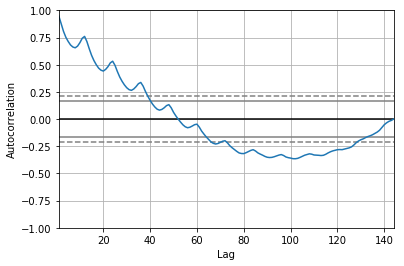

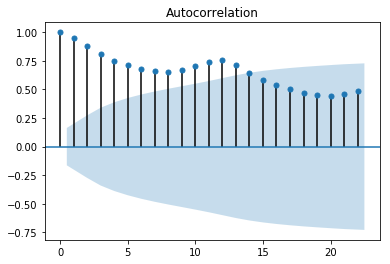

In [0]:
autocorrelation_plot(air_passengers.value.dropna())
acf_air_passengers_x = plot_acf(air_passengers.value.dropna())

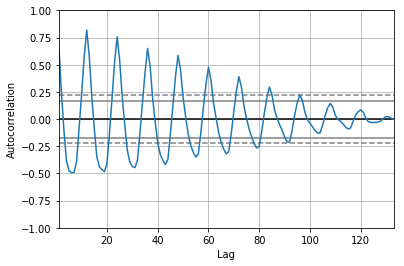

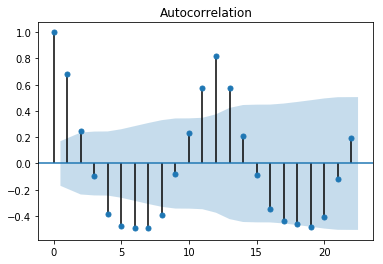

In [0]:
autocorrelation_plot(air_passengers_detrended.dropna())
acf_air_passengers_detrended_x = plot_acf(air_passengers_detrended.dropna())

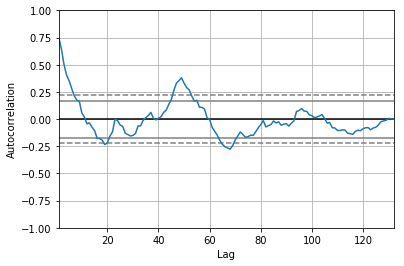

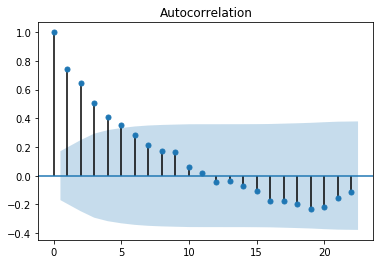

In [0]:

autocorrelation_plot(air_passengers_diff_by_12.dropna())
acf_air_passengers_diff_by_12_x = plot_acf(air_passengers_diff_by_12.dropna())

#### ACF for the birthday dataset

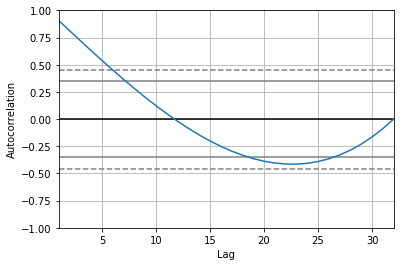

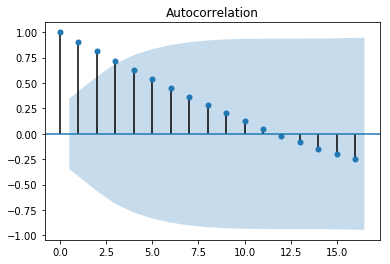

In [0]:
autocorrelation_plot(stamped_birthday_age_df.dropna())
acf_stamped_birthday_age_x = plot_acf(stamped_birthday_age_df.dropna())

# Episode 7 -- Bringing it all together

How do we combine all that knowledge?

In [0]:
int(air_passengers.size/4)

36

In [0]:
#air_passengers.iloc[air_passengers.size:int(air_passengers/4),:]
train_df = air_passengers[0:int(air_passengers.size*3/4)]
test_df = air_passengers[int(air_passengers.size*3/4):air_passengers.size]

In [0]:
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(np.asarray(train_df['value']))
fit_1 = model.fit()
pred_1 = fit_1.forecast(10)